<a href="https://colab.research.google.com/github/RiturajSingh2004/Liver-Disease-Datasets/blob/main/hcv_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import KNNImputer  # Using KNN imputation instead of SimpleImputer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
import xgboost as xgb
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

In [5]:
df_clean = pd.read_csv('hcv_cleaned_imputed.csv')
df_clean

,Category,Age,Sex,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT
0,0,32.0,1.0,38.5,52.50,7.7,22.1,7.5,6.93,3.23,106.0,12.1,69.0
1,0,32.0,1.0,38.5,70.30,18.0,24.7,3.9,11.17,4.80,74.0,15.6,76.5
2,0,32.0,1.0,46.9,74.70,36.2,52.6,6.1,8.84,5.20,86.0,33.2,79.3
3,0,32.0,1.0,43.2,52.00,30.6,22.6,18.9,7.33,4.74,80.0,33.8,75.7
4,0,32.0,1.0,39.2,74.10,32.6,24.8,9.6,9.15,4.32,76.0,29.9,68.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...
610,4,62.0,0.0,32.0,416.60,5.9,110.3,50.0,5.57,6.30,55.7,650.9,68.5
611,4,64.0,0.0,24.0,102.80,2.9,44.4,20.0,1.54,3.02,63.0,35.9,71.3
612,4,64.0,0.0,29.0,87.30,3.5,99.0,48.0,1.66,3.63,66.7,64.2,82.0
613,4,46.0,0.0,33.0,58.78,39.0,62.0,20.0,3.56,4.20,52.0,50.0,71.0


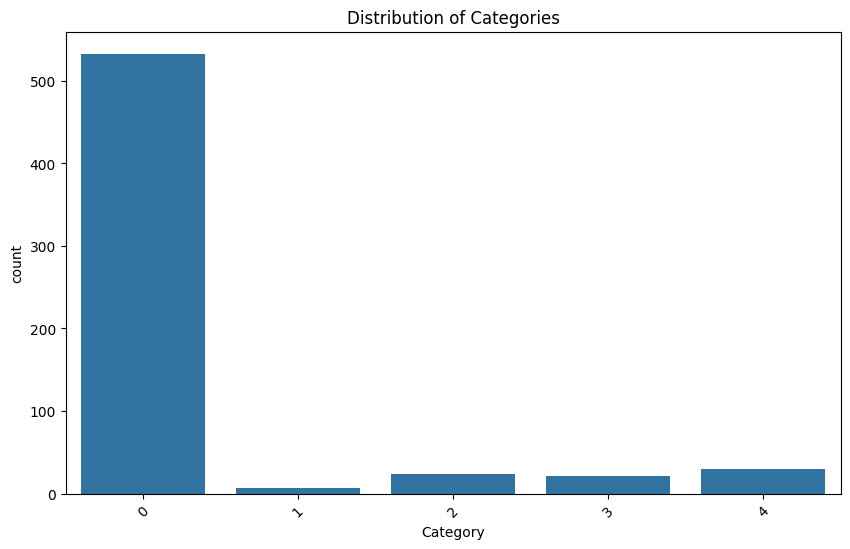

In [6]:
# Exploratory Data Analysis
plt.figure(figsize=(10, 6))
sns.countplot(x='Category', data=df_clean)
plt.title('Distribution of Categories')
plt.xticks(rotation=45)
plt.show()

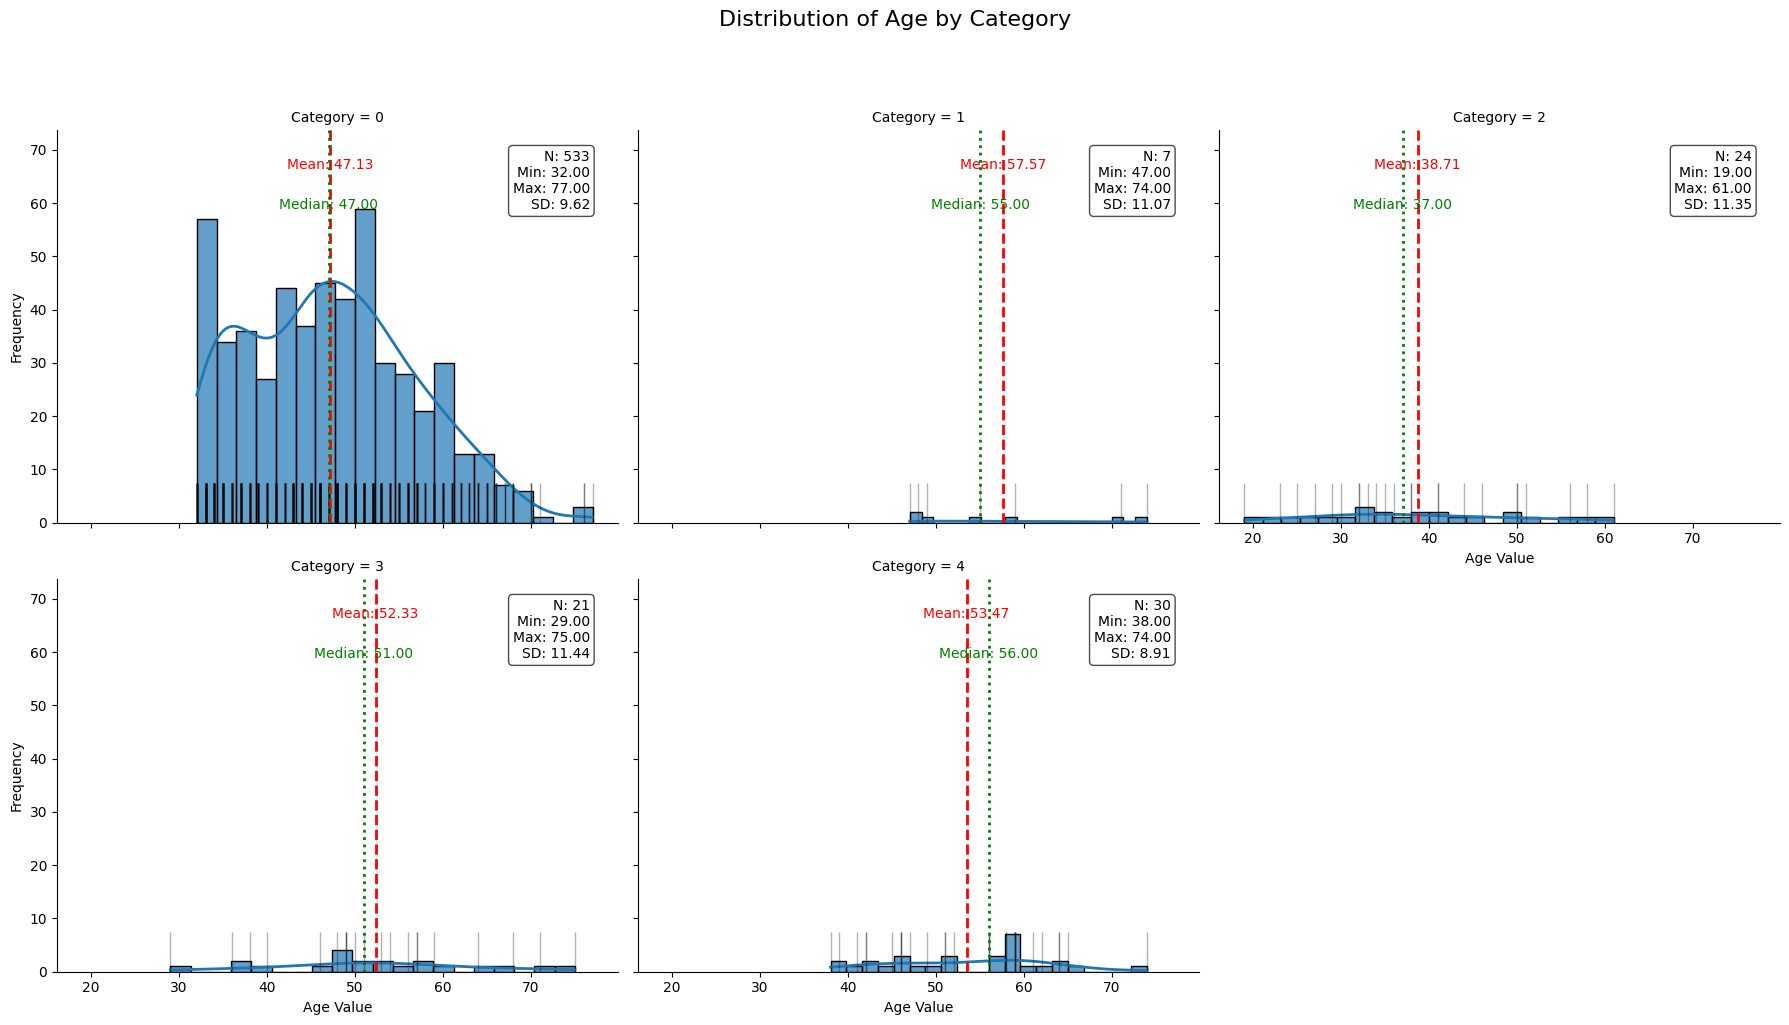

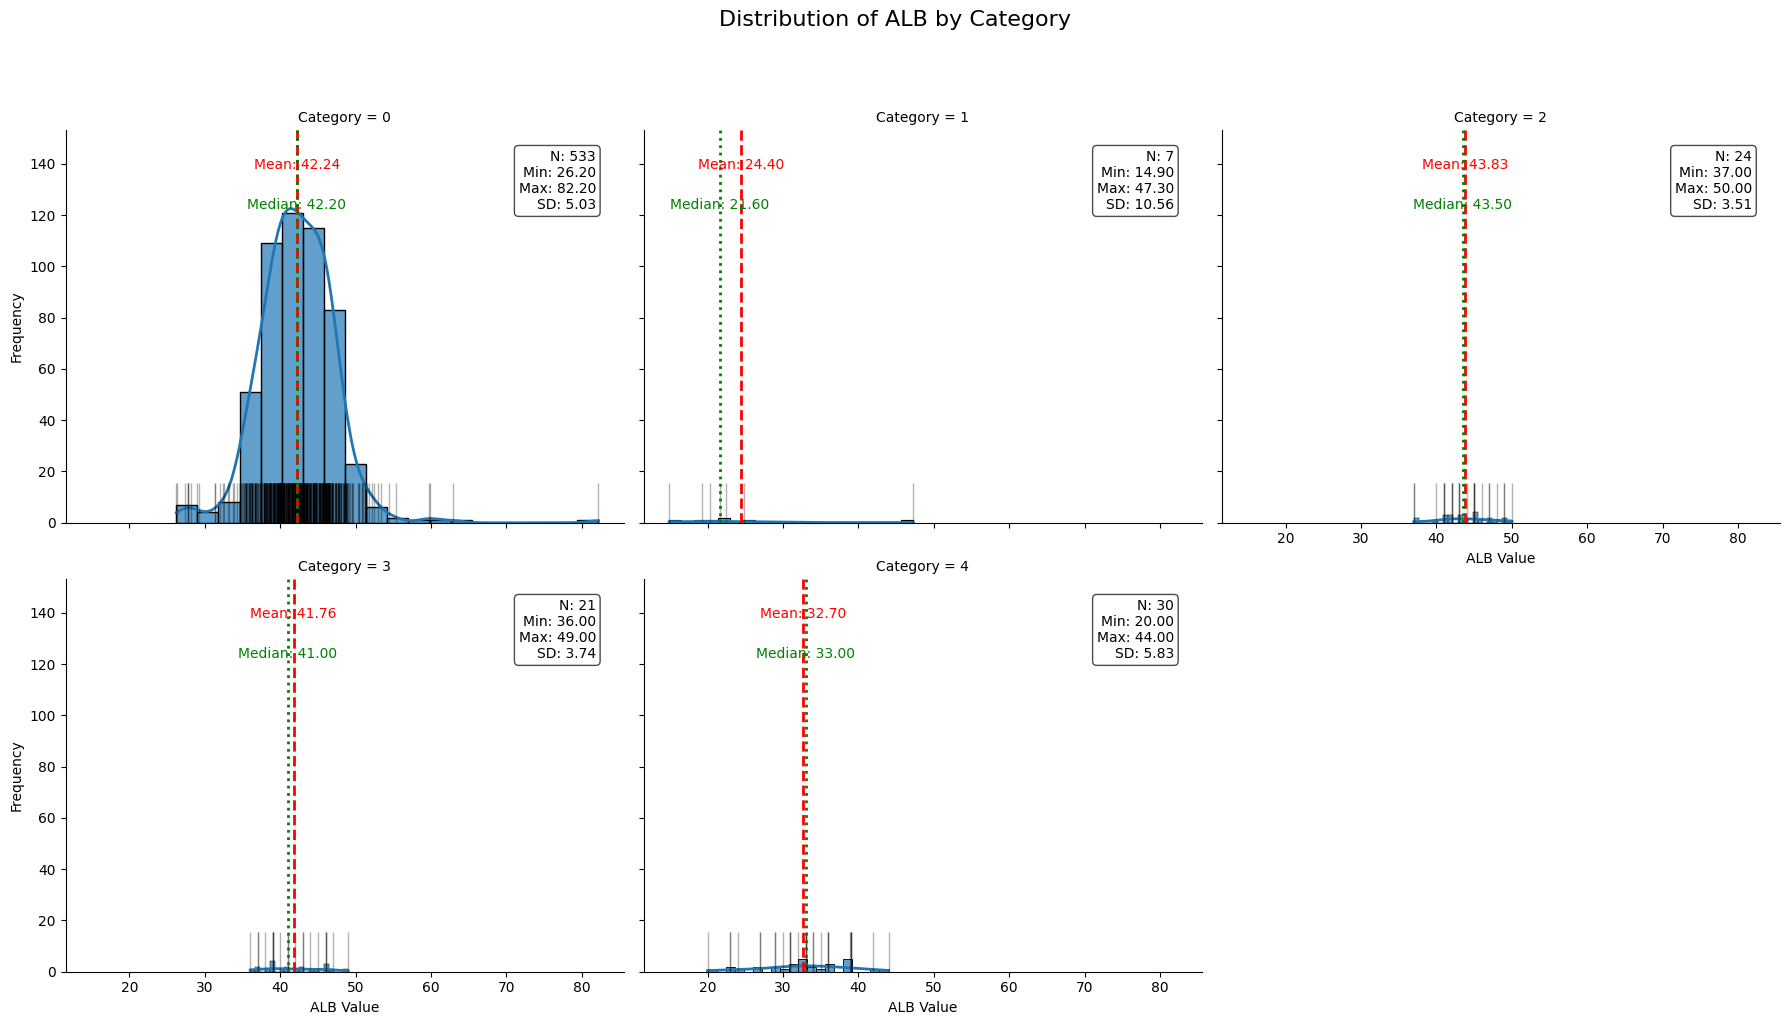

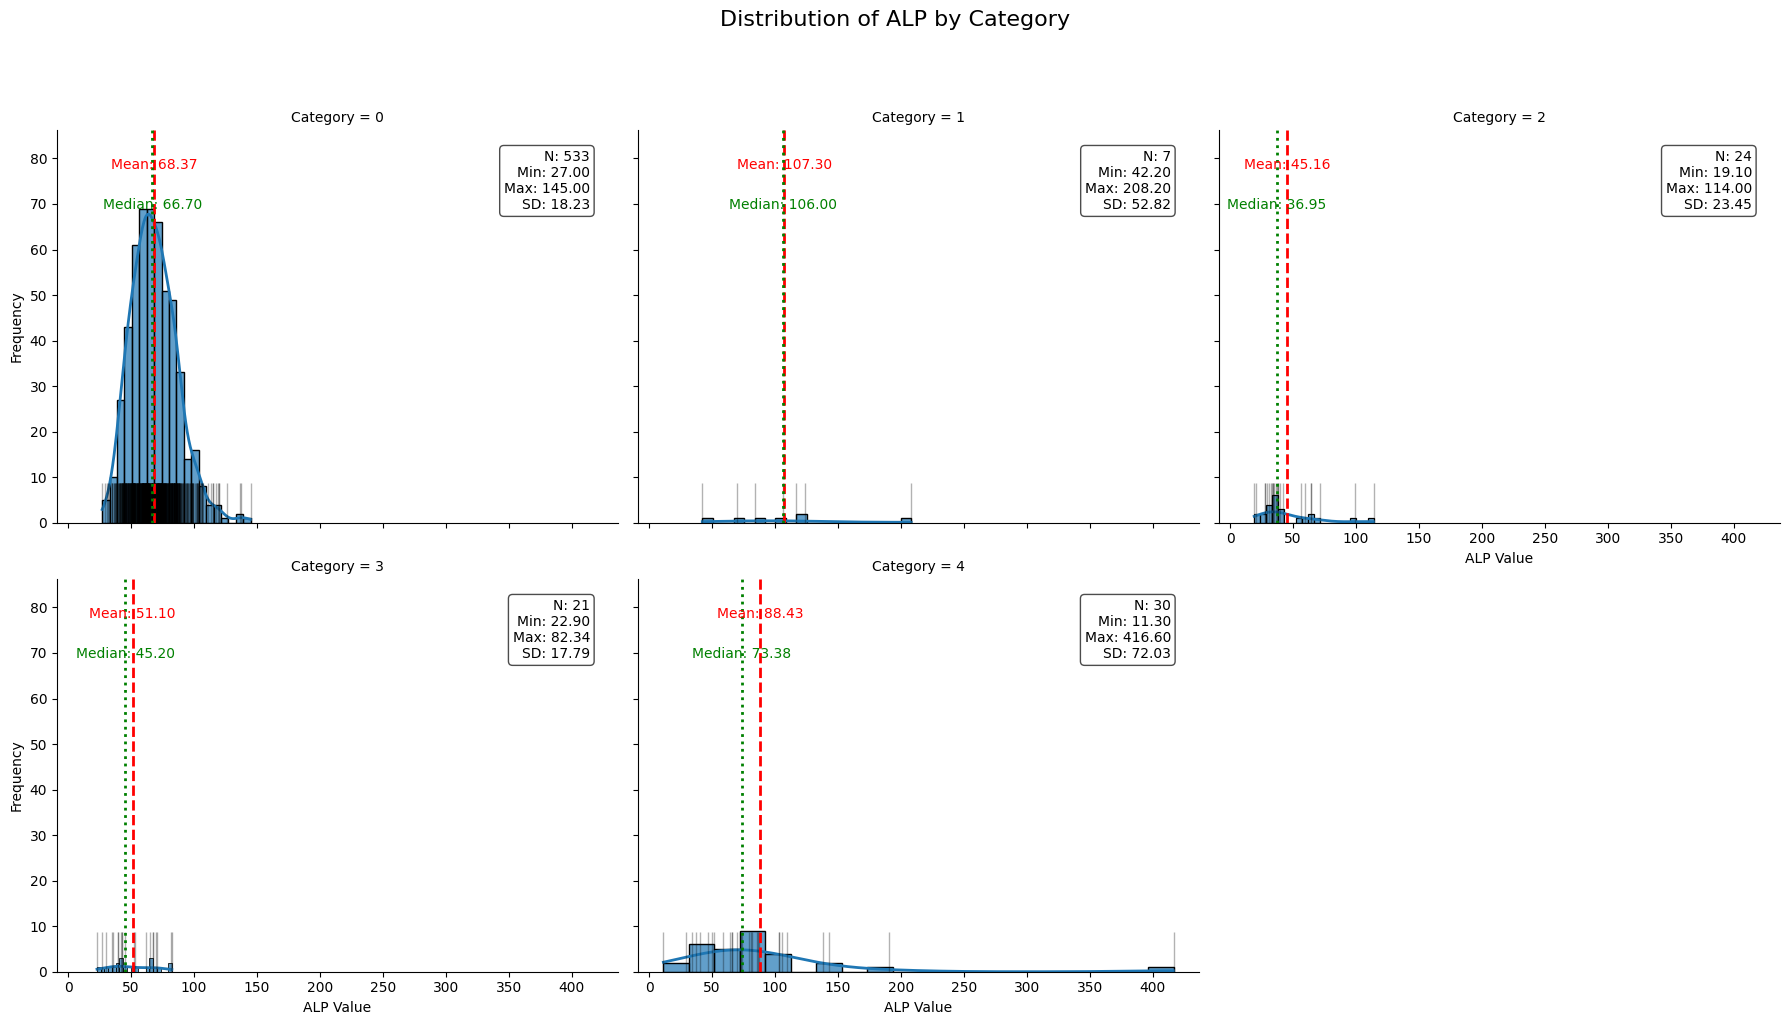

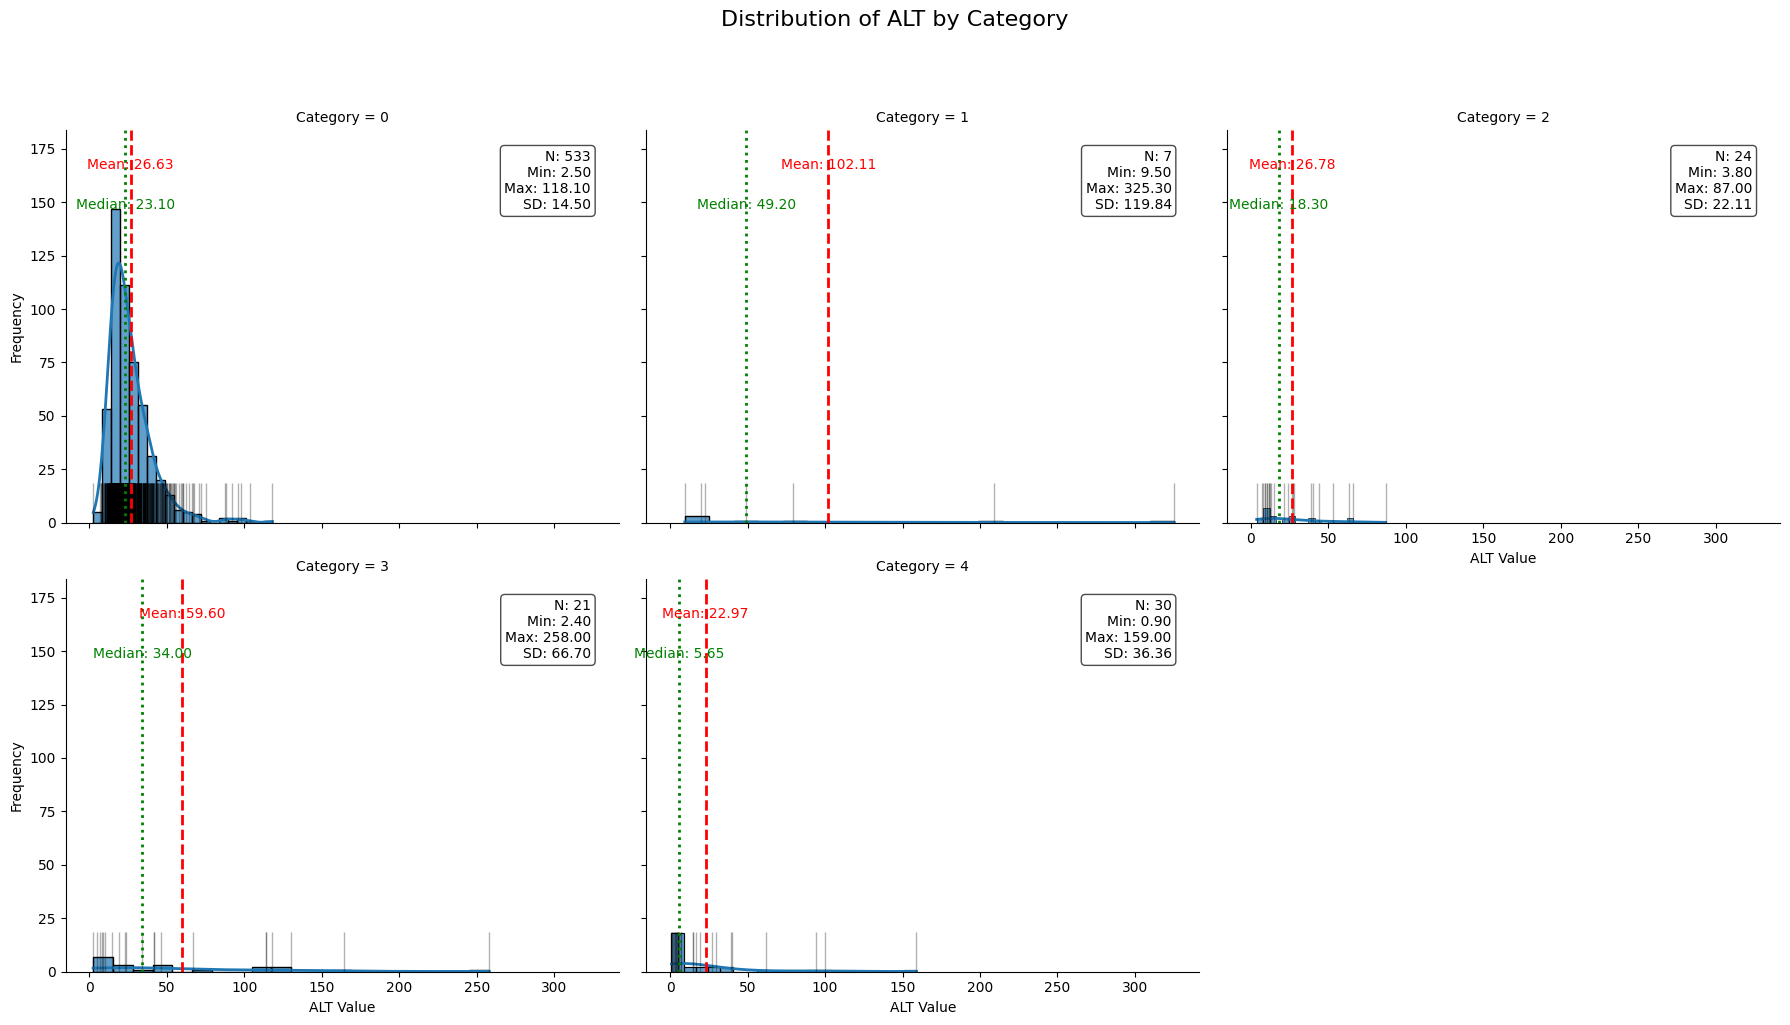

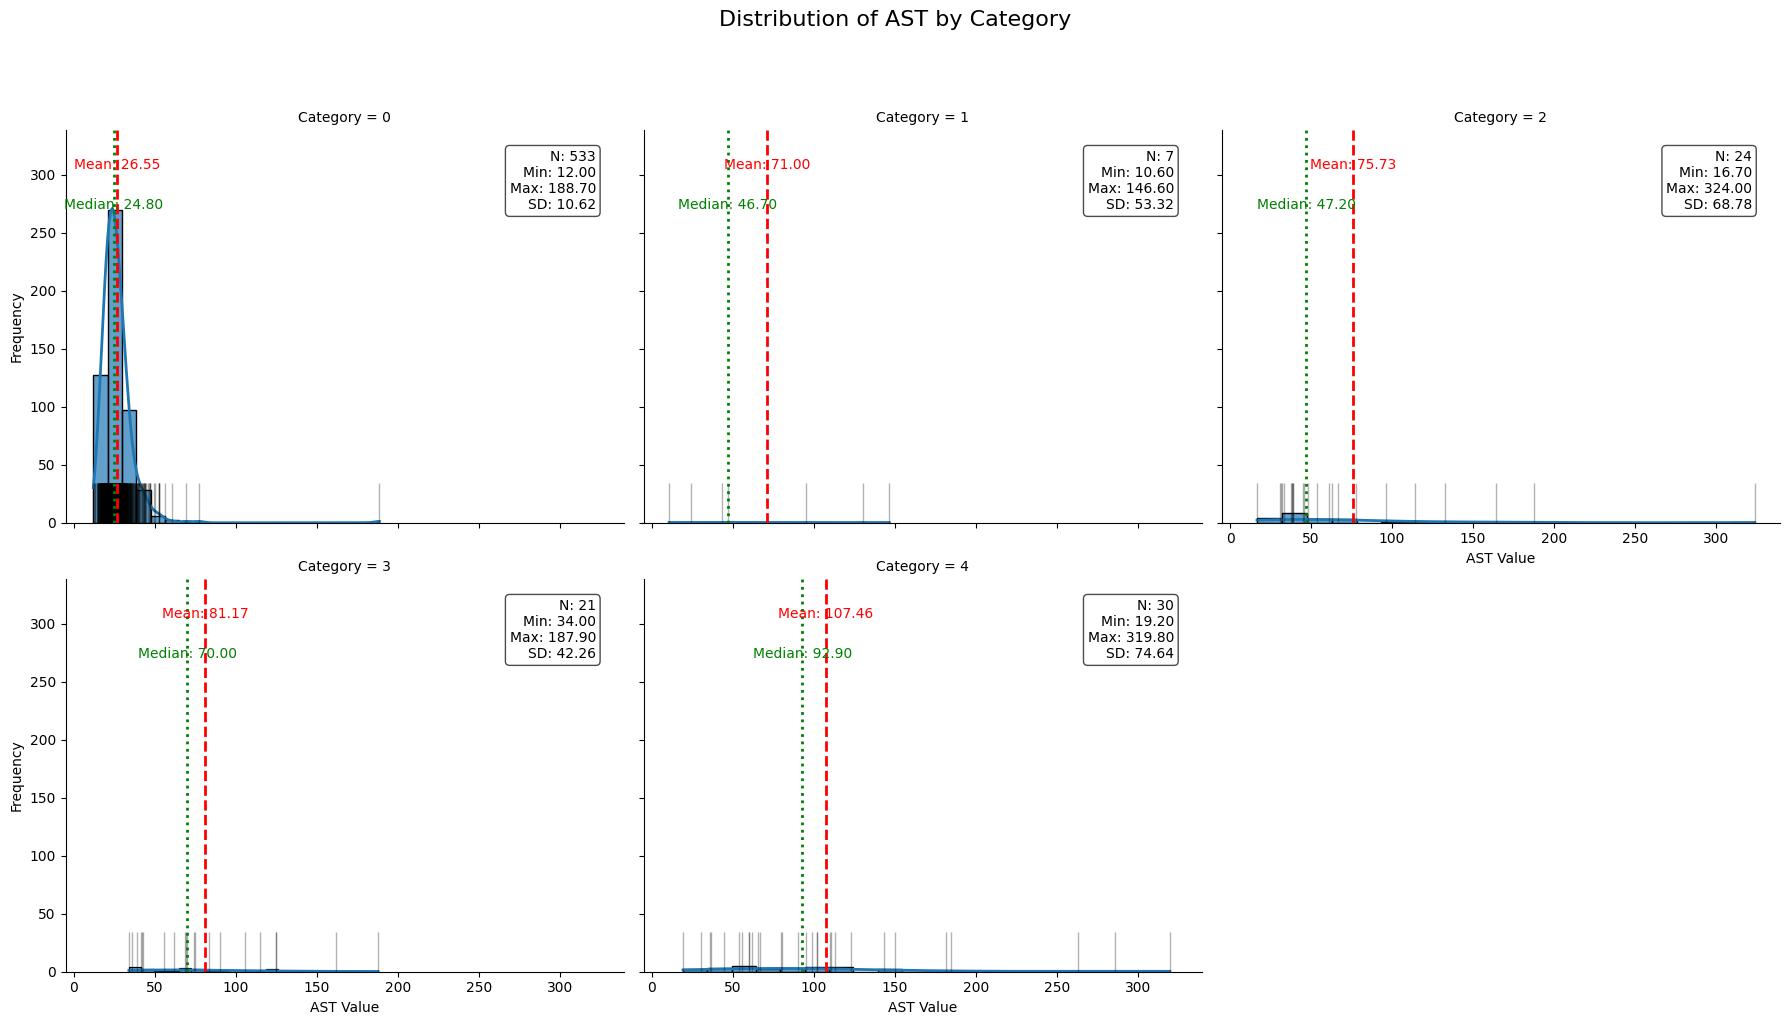

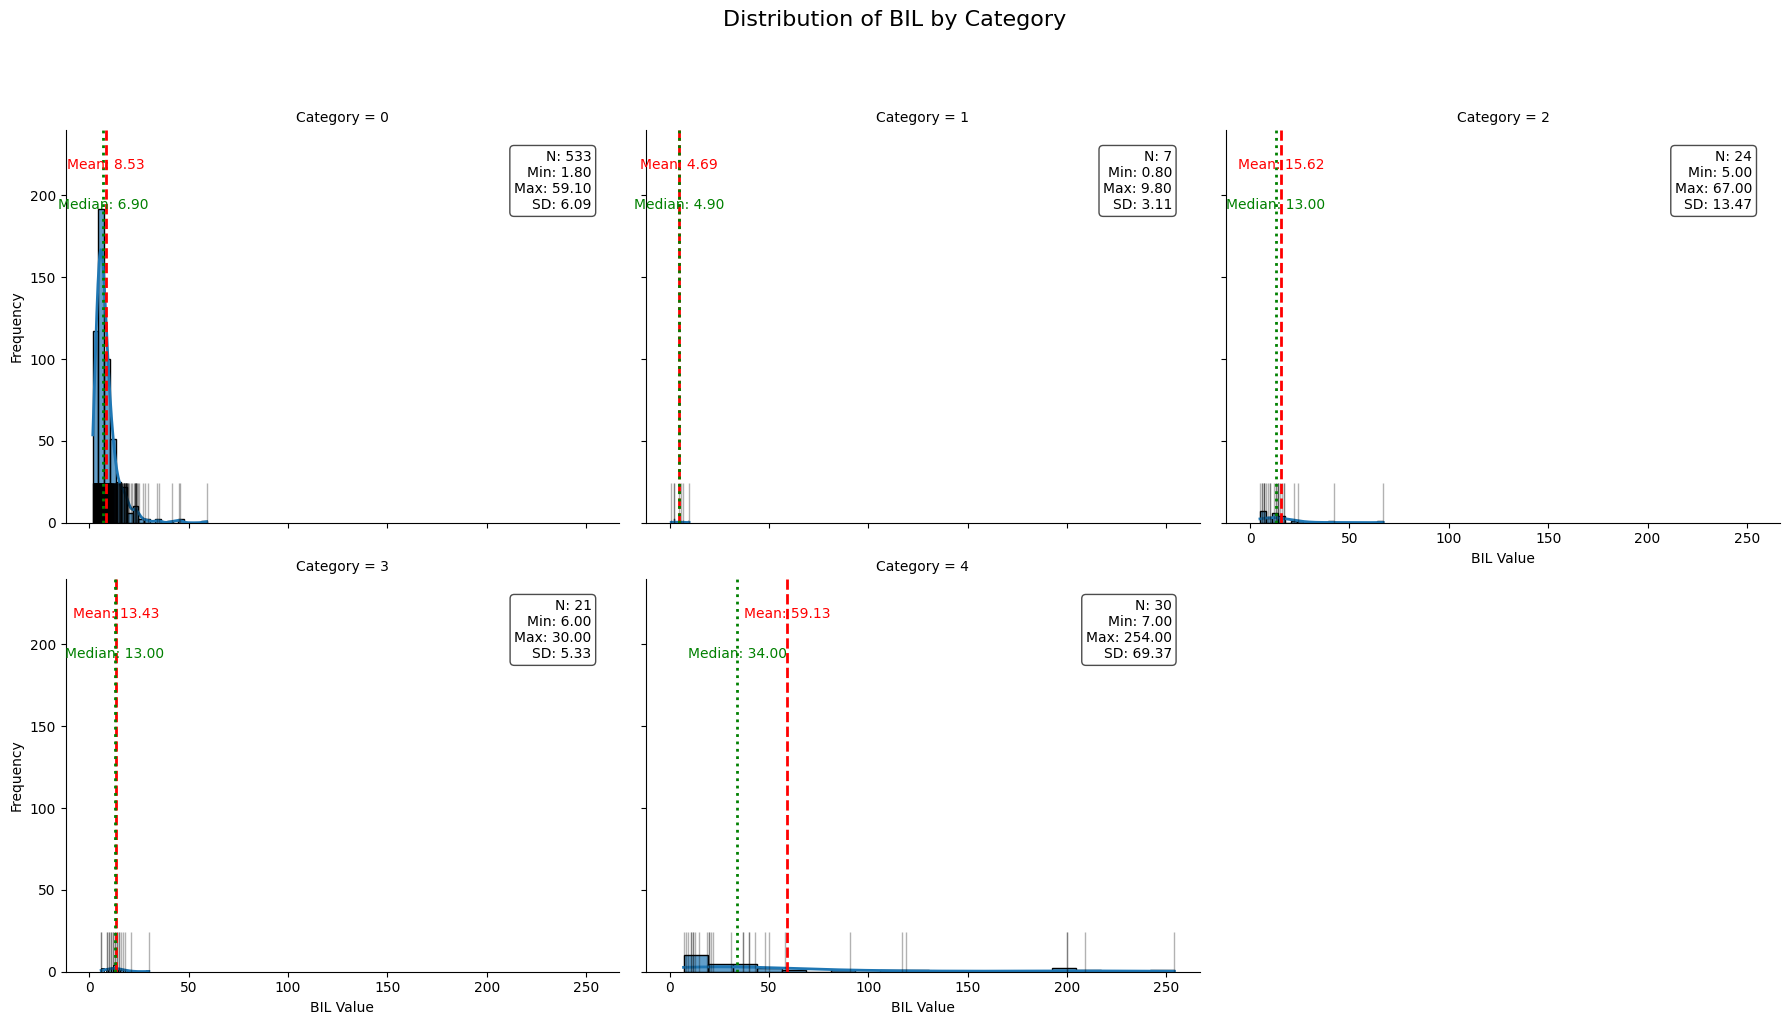

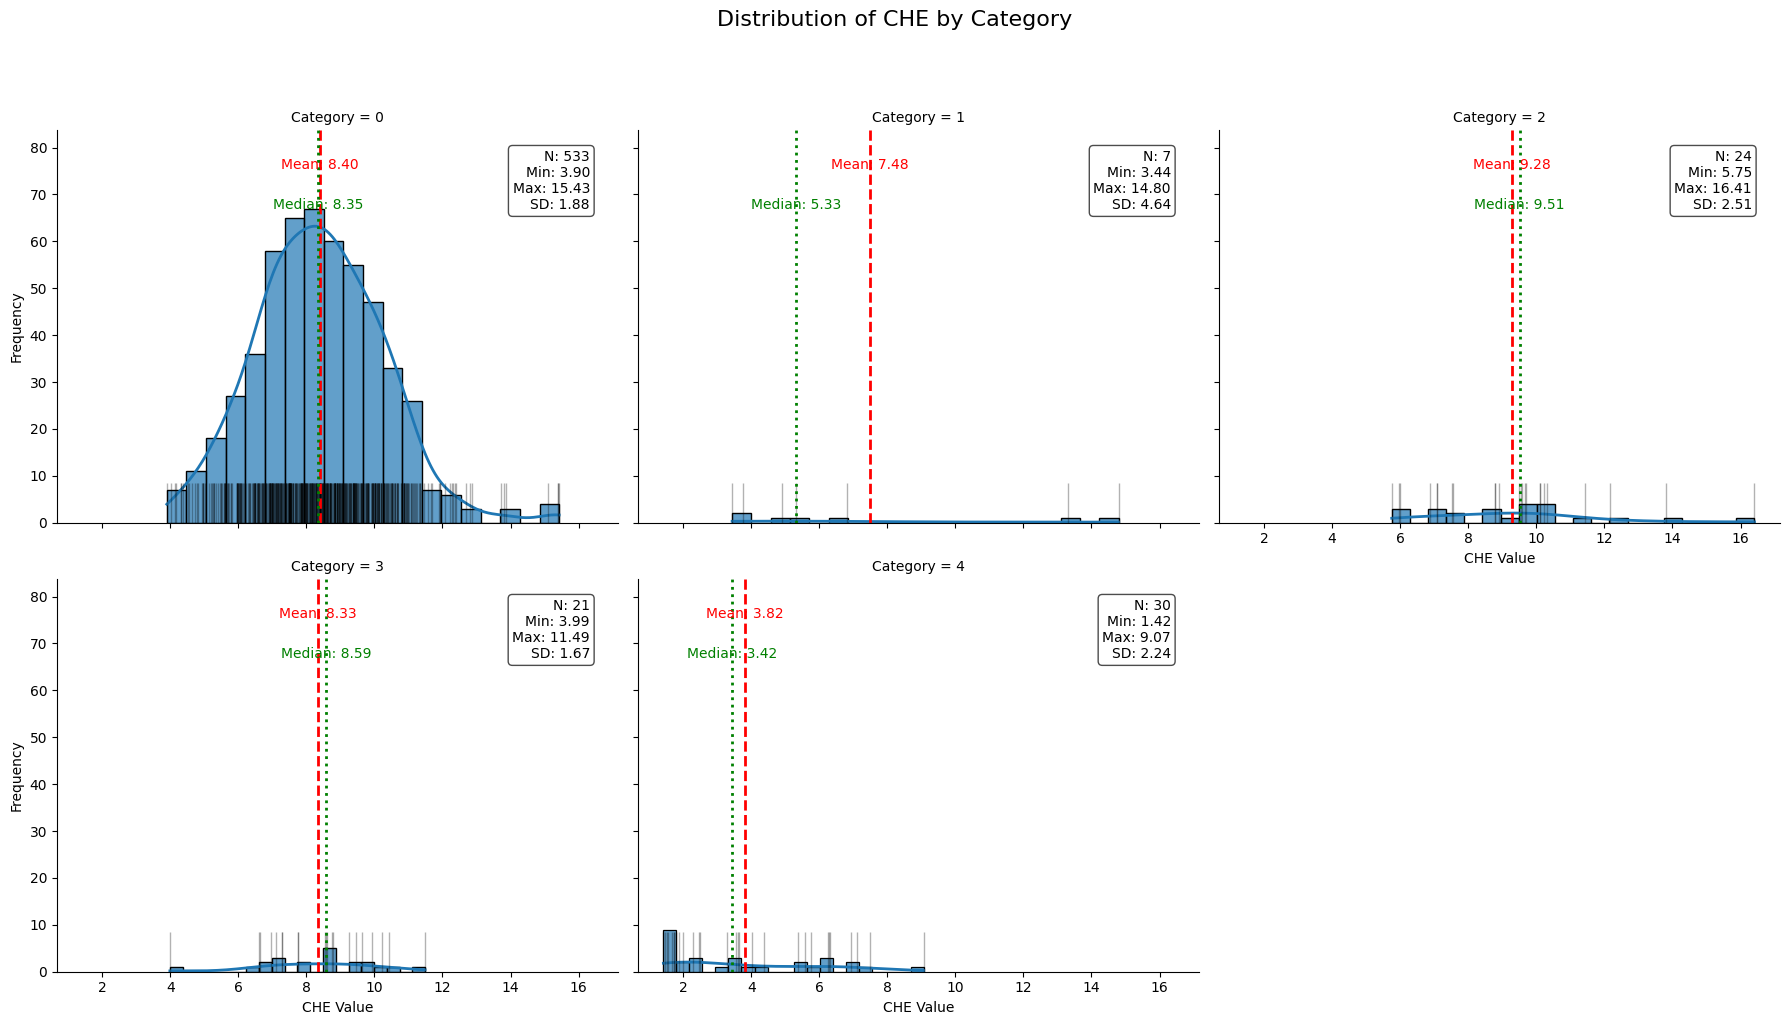

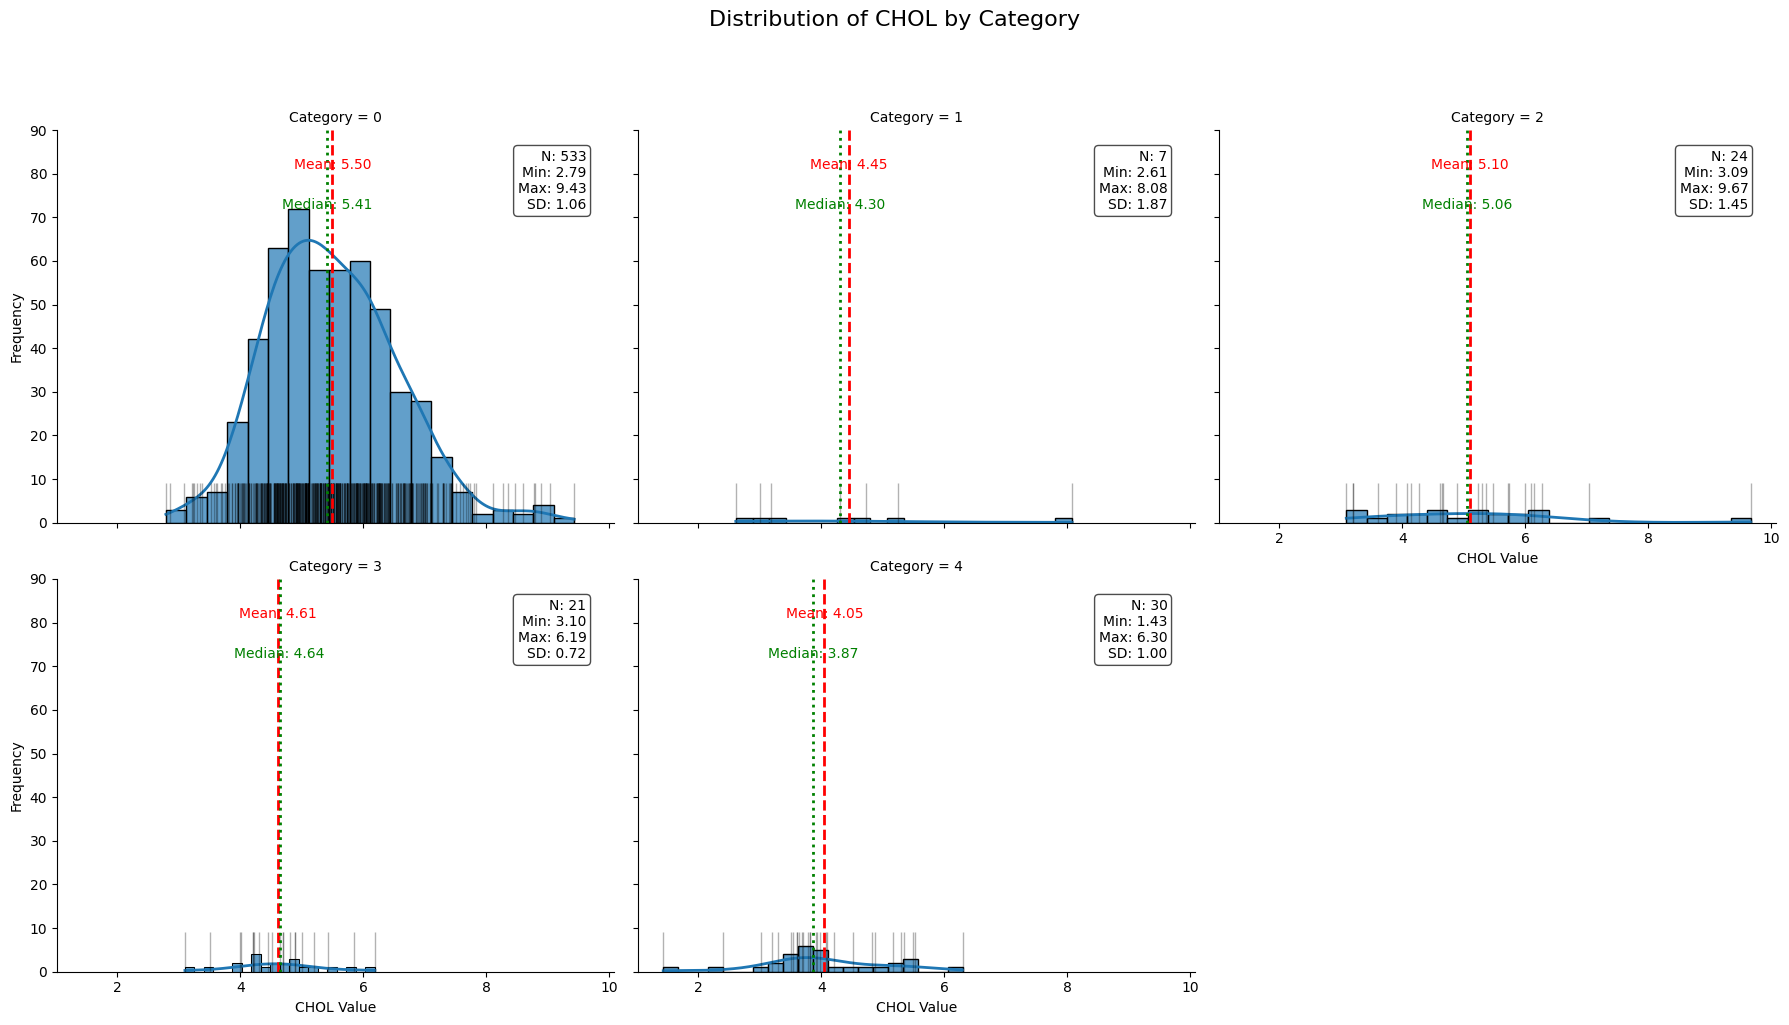

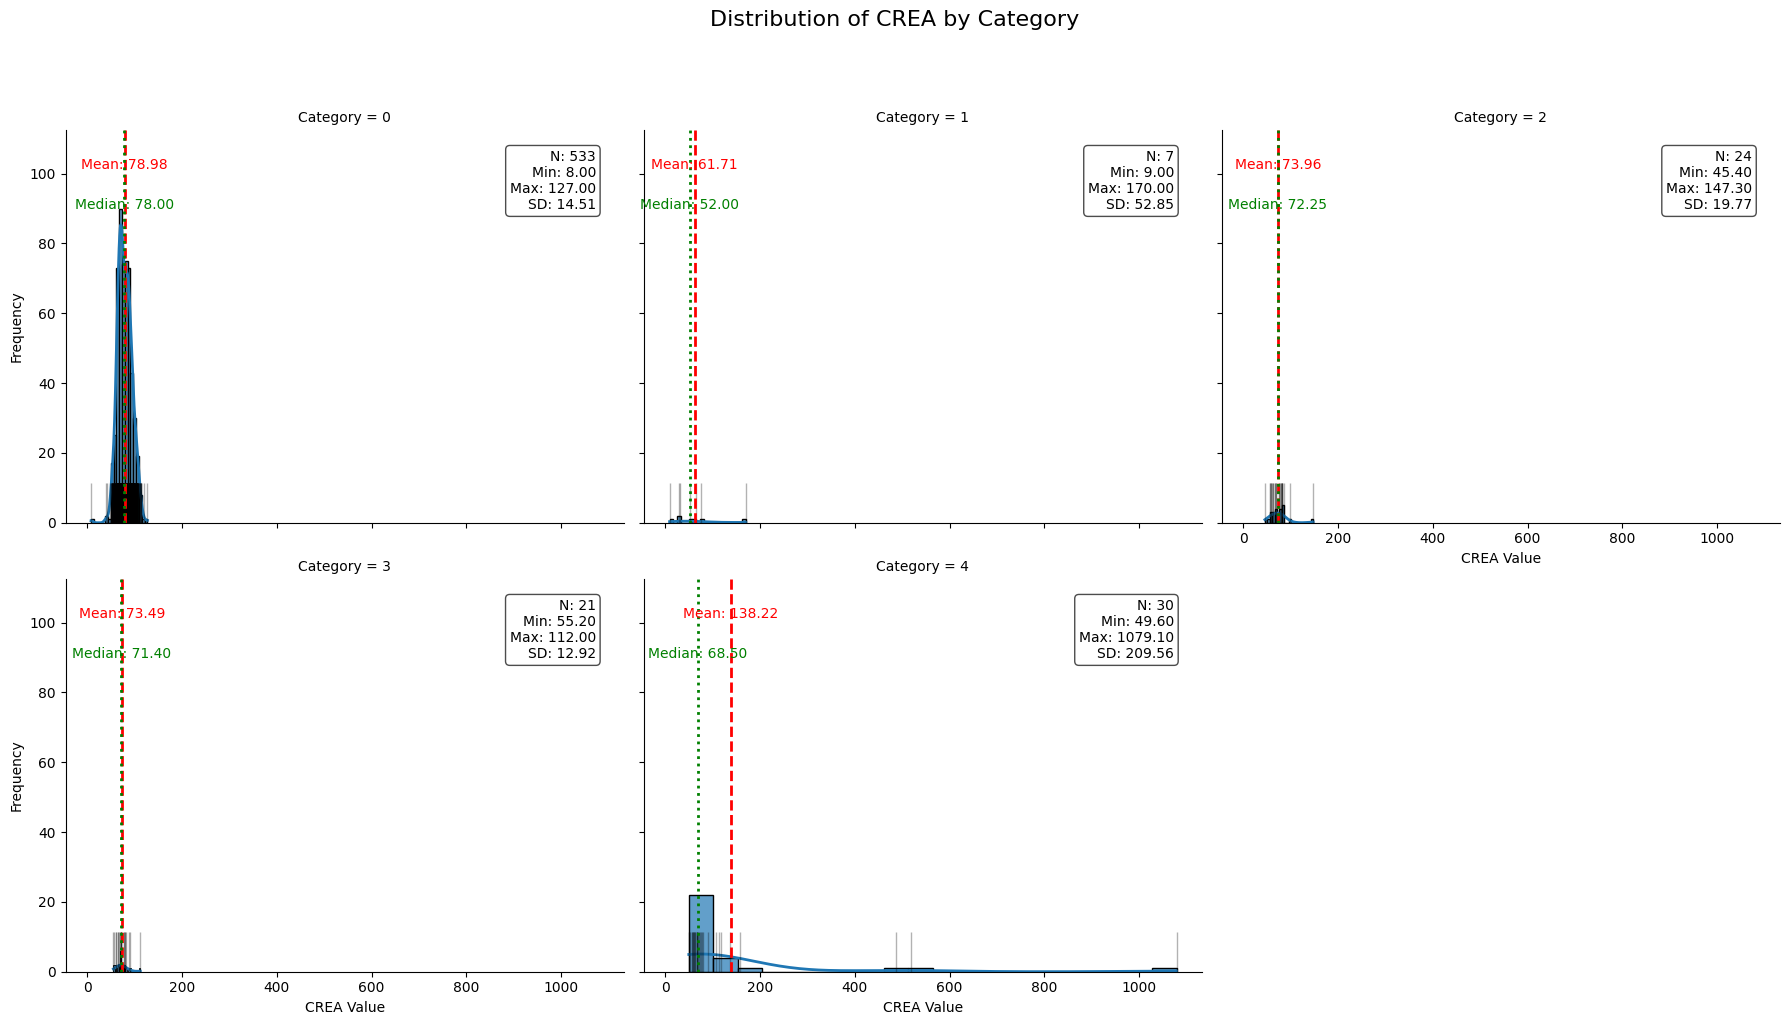

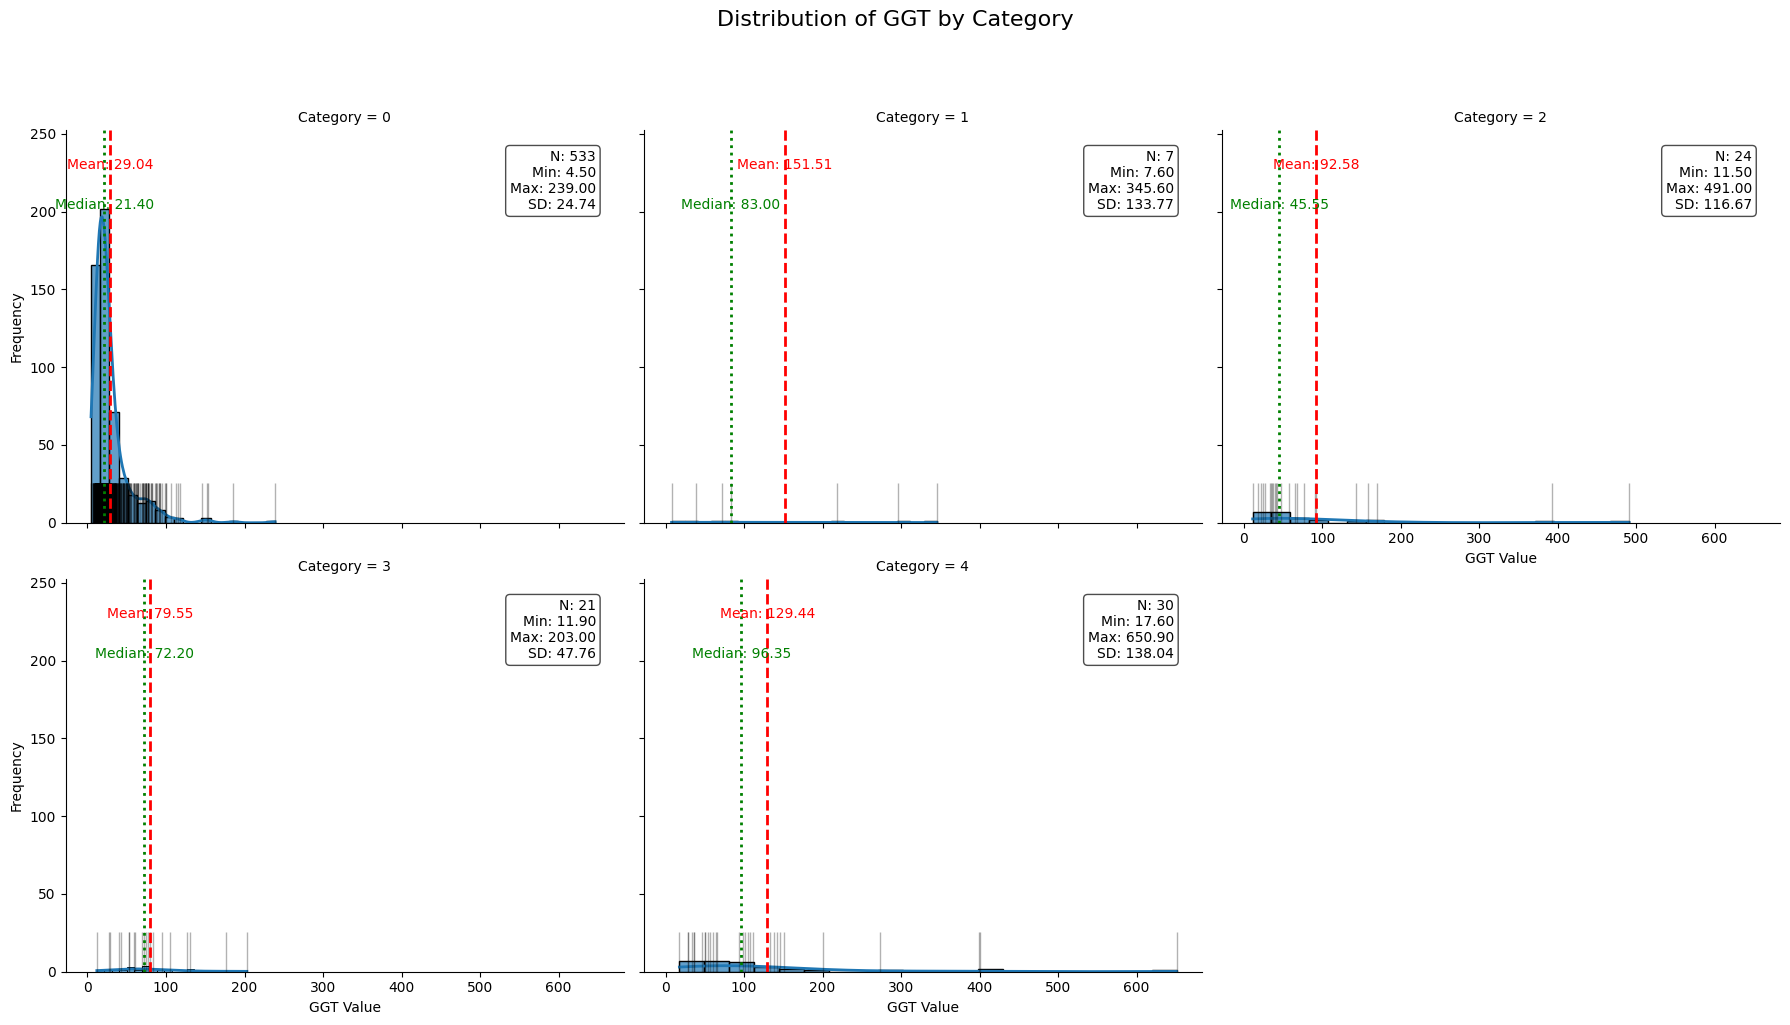

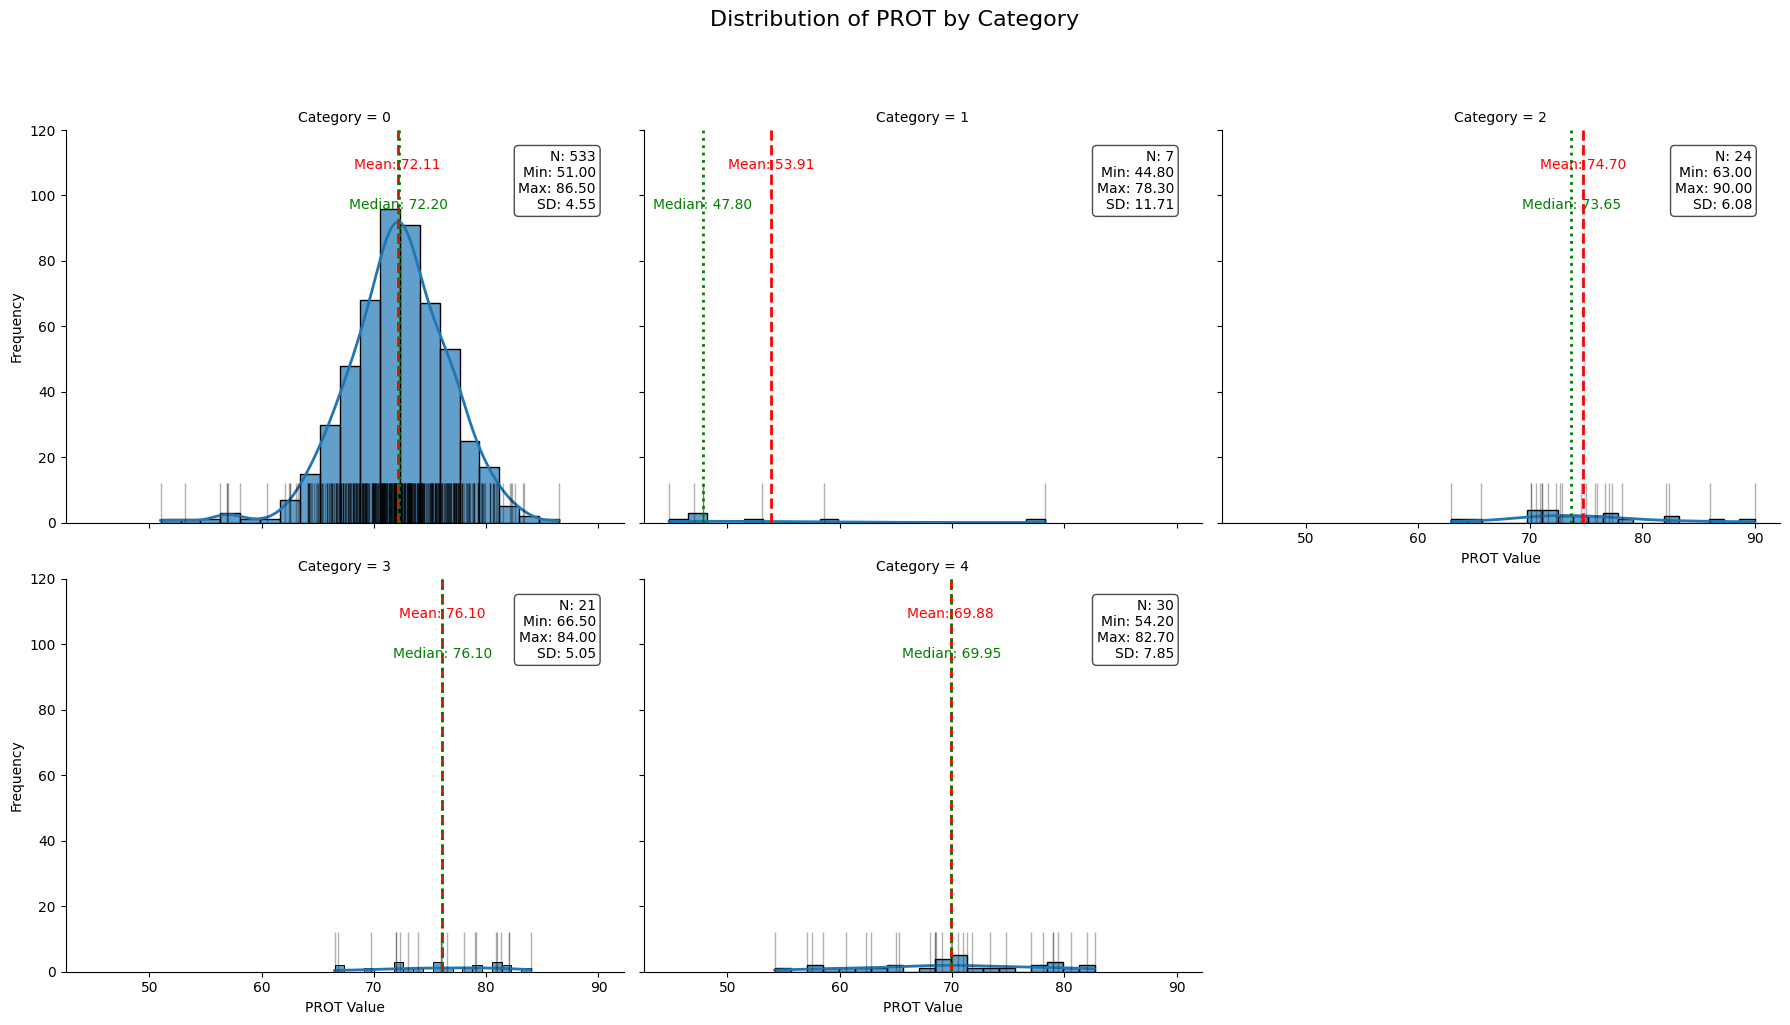

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


# Define features (all numerical columns except 'Category' and any non-numerical columns like 'Sex')
features = ['Age', 'ALB', 'ALP', 'ALT', 'AST', 'BIL', 'CHE', 'CHOL', 'CREA', 'GGT', 'PROT']

# Iterate over features to create detailed faceted histograms
for feature in features:
    # Create a more detailed faceted histogram
    g = sns.FacetGrid(df_clean, col='Category', col_wrap=3, height=5, aspect=1.2)

    # Add both histogram and KDE with more bins for detail
    g.map_dataframe(sns.histplot, x=feature, kde=True, bins=20,
                   line_kws={'linewidth': 2}, alpha=0.7)

    # Add individual data points as rugs at the bottom
    g.map(sns.rugplot, feature, color='black', alpha=0.3, height=0.1)

    # Add mean line with annotation
    def show_mean(x, **kwargs):
        plt.axvline(x.mean(), color='red', linestyle='--', linewidth=2)
        plt.text(x.mean(), plt.gca().get_ylim()[1]*0.9,
                f'Mean: {x.mean():.2f}', color='red', ha='center')

    g.map(show_mean, feature)

    # Add median line
    def show_median(x, **kwargs):
        plt.axvline(x.median(), color='green', linestyle=':', linewidth=2)
        plt.text(x.median(), plt.gca().get_ylim()[1]*0.8,
                f'Median: {x.median():.2f}', color='green', ha='center')

    g.map(show_median, feature)

    # Enhance the plot with better titles and labels
    g.fig.suptitle(f'Distribution of {feature} by Category', fontsize=16, y=1.02)
    g.set_axis_labels(f'{feature} Value', 'Frequency')

    # Add category-specific statistics in each subplot
    for ax, category in zip(g.axes.flat, g.col_names):
        category_data = df_clean[df_clean['Category'] == category][feature]
        stats_text = f"N: {len(category_data)}\n"
        stats_text += f"Min: {category_data.min():.2f}\n"
        stats_text += f"Max: {category_data.max():.2f}\n"
        stats_text += f"SD: {category_data.std():.2f}"
        ax.text(0.95, 0.95, stats_text, transform=ax.transAxes,
               fontsize=10, va='top', ha='right',
               bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

    g.fig.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()


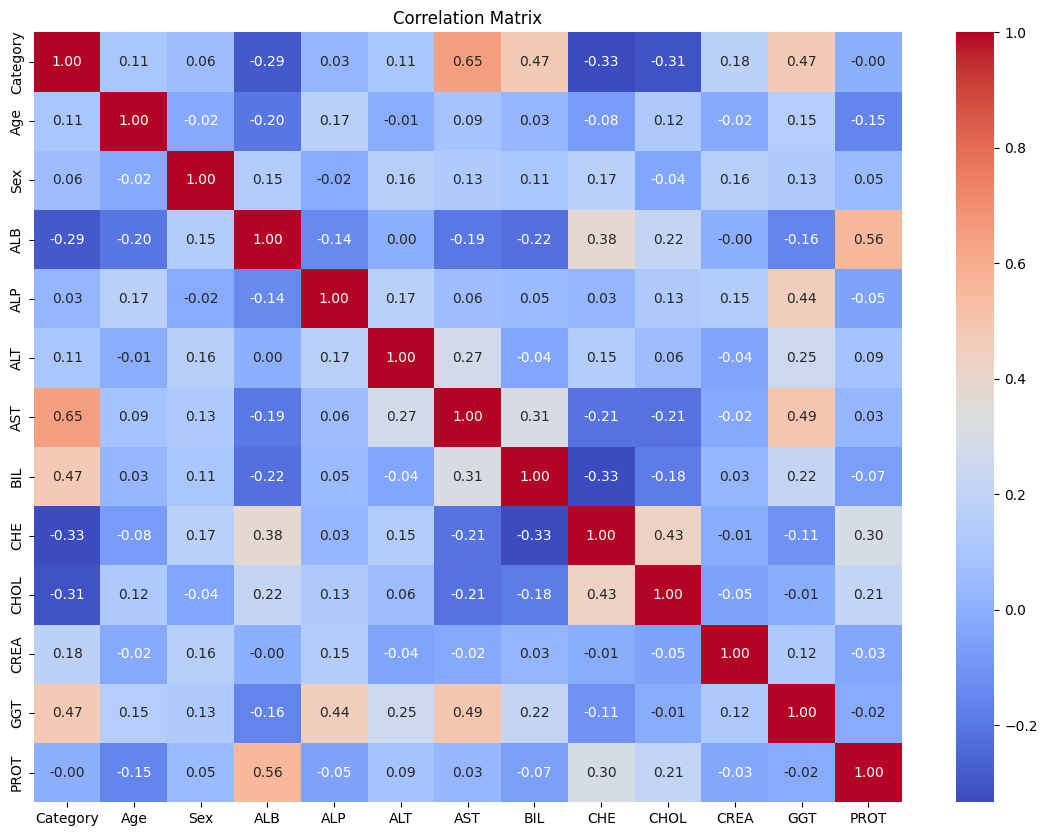

In [9]:
# Define numerical columns
numerical_cols = df_clean.select_dtypes(include=['float64', 'int64']).columns

# Then create the correlation matrix
plt.figure(figsize=(14, 10))
correlation = df_clean[numerical_cols].corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()


1.Strong correlation between Category and AST: There's a moderate positive correlation (0.65) between the Category (disease stage) and AST (aspartate aminotransferase) levels, indicating that AST is a strong predictor of liver disease progression.

2.Bilirubin correlations: BIL (bilirubin) shows moderate positive correlation (0.47) with both Category and AST, confirming its clinical relevance in liver disease assessment.

3.GGT as a predictor: GGT (gamma-glutamyl transferase) shows a moderate positive correlation (0.47) with Category and AST (0.49), making it another valuable marker for disease progression.

4.Negative correlations with CHE and CHOL: Both CHE (cholinesterase) and CHOL (cholesterol) show negative correlations with Category (-0.33 and -0.31 respectively), suggesting that these values tend to decrease as liver disease progresses.

5.ALB negative correlation: ALB (albumin) shows a negative correlation (-0.29) with Category, which aligns with clinical knowledge that albumin levels typically decrease in advanced liver disease.

6.Weak correlations with demographic factors: Age and Sex show relatively weak correlations with Category (0.11 and 0.06 respectively), suggesting that demographic factors are less predictive of disease stage than biochemical markers.

7.Interrelated liver enzymes: There are multiple correlations between liver enzymes (AST, ALT, GGT), confirming their biological relationship in liver function assessment.

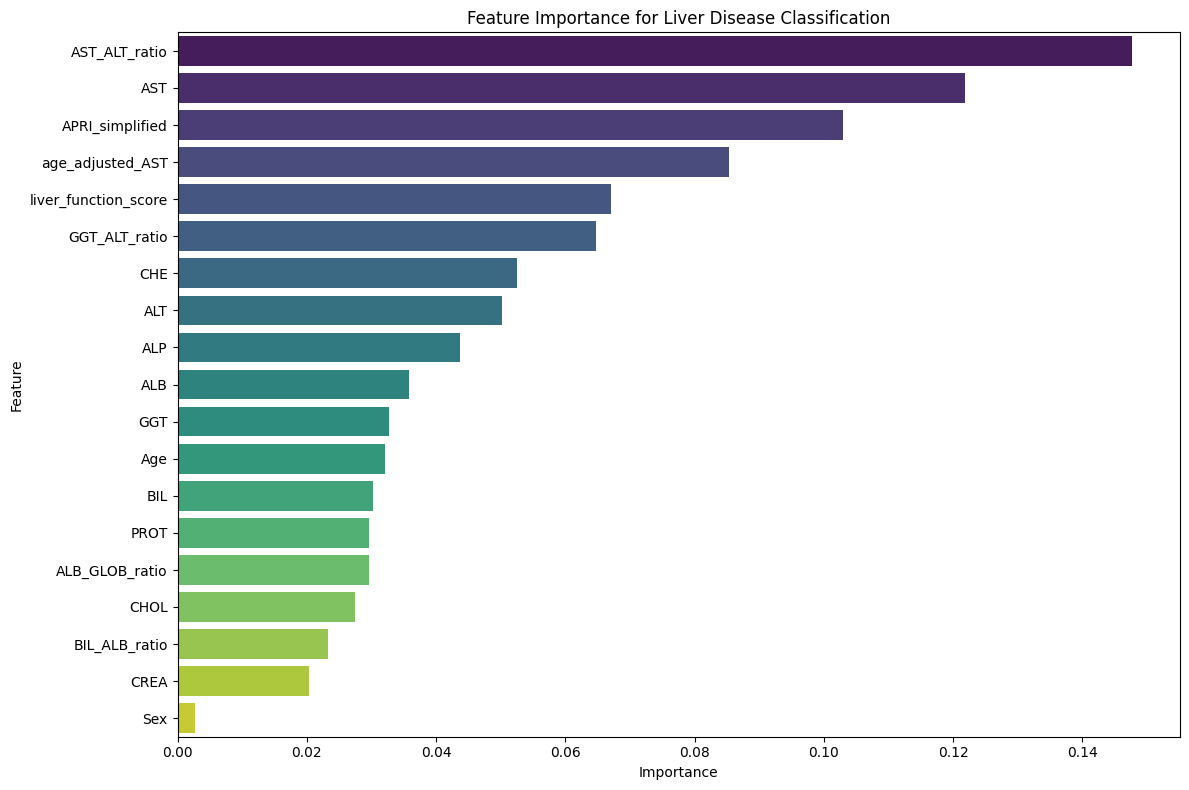

In [12]:
# Create new features that might be helpful
# AST/ALT ratio (De Ritis ratio) - crucial for liver disease assessment
df_clean['AST_ALT_ratio'] = df_clean['AST'] / df_clean['ALT']

# APRI score (AST to Platelet Ratio Index) - simplified version without platelet count
df_clean['APRI_simplified'] = df_clean['AST'] / df_clean['PROT']

# ALB/GLOB ratio - important for liver function assessment
df_clean['ALB_GLOB_ratio'] = df_clean['ALB'] / (df_clean['PROT'] - df_clean['ALB'])

# BIL/ALB ratio - indicates liver's ability to process bilirubin
df_clean['BIL_ALB_ratio'] = df_clean['BIL'] / df_clean['ALB']

# GGT/ALT ratio - helps distinguish alcoholic vs viral liver disease
df_clean['GGT_ALT_ratio'] = df_clean['GGT'] / df_clean['ALT']

# Liver function composite score
df_clean['liver_function_score'] = (df_clean['ALB'] / 10) - (df_clean['BIL'] / 20) - (df_clean['AST'] / 100)

# Age-adjusted AST - age is a risk factor for progression
df_clean['age_adjusted_AST'] = df_clean['AST'] * (df_clean['Age'] / 40)

# Replace infinities with NaN and then impute
df_clean.replace([np.inf, -np.inf], np.nan, inplace=True)
df_clean.fillna(df_clean.median(), inplace=True)

# Feature importance using Random Forest
X = df_clean.drop(['Category'], axis=1)
y = df_clean['Category']

# Train a Random Forest classifier on the full dataset
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)

# Plot feature importance
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance, palette='viridis')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance for Liver Disease Classification')
plt.tight_layout()
plt.show()

In [13]:
# Select top features
top_features = feature_importance['Feature'][:15].tolist()
print("Top 15 features:", top_features)

# Prepare data for modeling
X_selected = df_clean[top_features]

Top 15 features: ['AST_ALT_ratio', 'AST', 'APRI_simplified', 'age_adjusted_AST', 'liver_function_score', 'GGT_ALT_ratio', 'CHE', 'ALT', 'ALP', 'ALB', 'GGT', 'Age', 'BIL', 'PROT', 'ALB_GLOB_ratio']


In [14]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42, stratify=y)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Check for class imbalance
print("Class distribution in training set:")
print(y_train.value_counts())

Class distribution in training set:
Category
0    426
4     24
2     19
3     17
1      6
Name: count, dtype: int64


In [15]:
# Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

print("Class distribution after SMOTE:")
print(pd.Series(y_train_resampled).value_counts())

Class distribution after SMOTE:
Category
2    426
0    426
4    426
3    426
1    426
Name: count, dtype: int64


In [16]:
# Train multiple models
models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': xgb.XGBClassifier(random_state=42)
}


In [17]:
# Function to evaluate models
def evaluate_model(model, X_train, y_train, X_test, y_test):
    # Train the model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)

    # Print classification report
    print(f"Classification Report:\n{classification_report(y_test, y_pred)}")
    # Create confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - Accuracy: {accuracy:.4f}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    return accuracy, model


Evaluating Random Forest...
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       107
           1       1.00      1.00      1.00         1
           2       0.60      0.60      0.60         5
           3       0.60      0.75      0.67         4
           4       1.00      0.83      0.91         6

    accuracy                           0.96       123
   macro avg       0.84      0.83      0.83       123
weighted avg       0.96      0.96      0.96       123



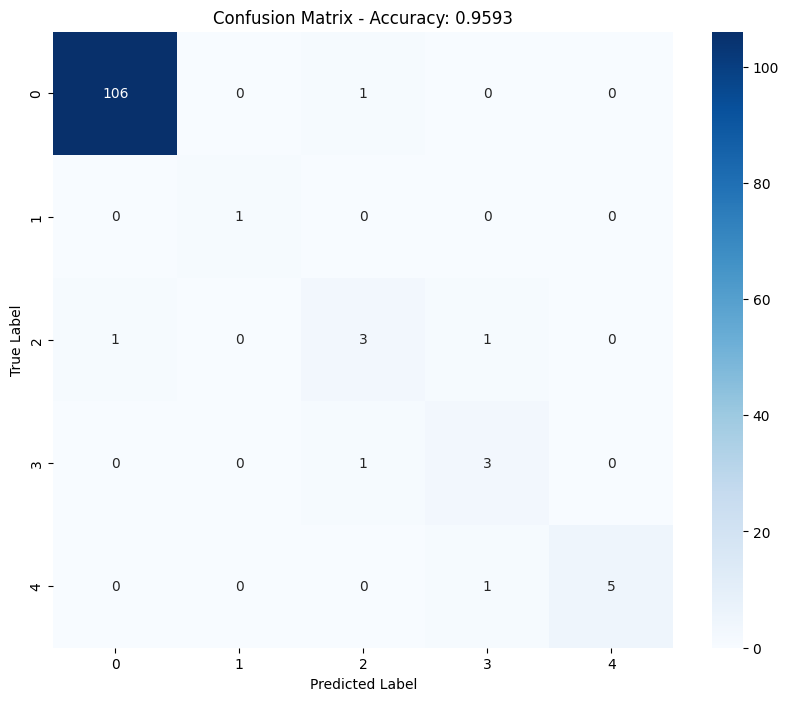


Evaluating Gradient Boosting...
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       107
           1       1.00      1.00      1.00         1
           2       0.57      0.80      0.67         5
           3       0.67      1.00      0.80         4
           4       1.00      0.67      0.80         6

    accuracy                           0.96       123
   macro avg       0.85      0.89      0.85       123
weighted avg       0.97      0.96      0.96       123



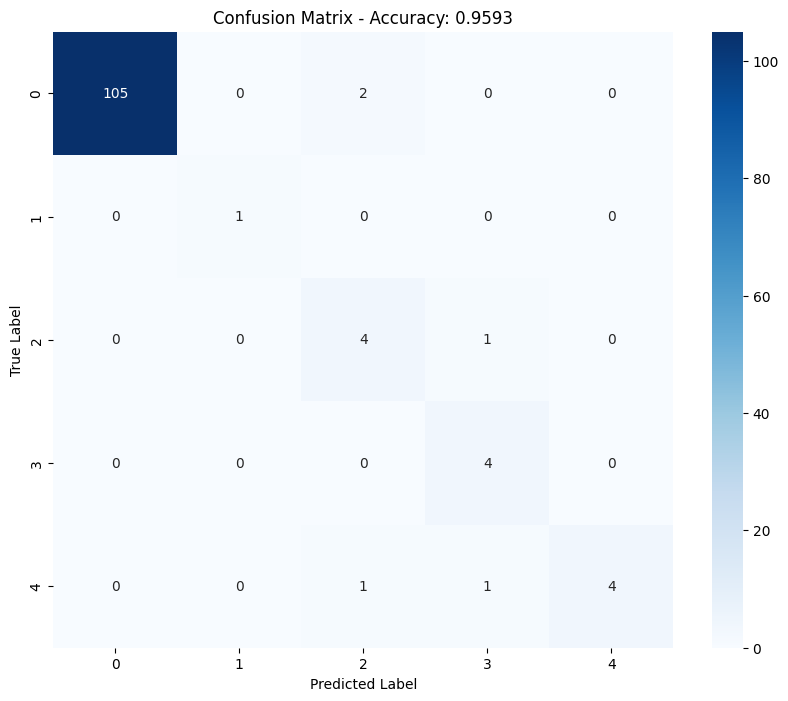


Evaluating XGBoost...
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       107
           1       1.00      1.00      1.00         1
           2       0.60      0.60      0.60         5
           3       0.67      1.00      0.80         4
           4       1.00      0.83      0.91         6

    accuracy                           0.96       123
   macro avg       0.85      0.88      0.86       123
weighted avg       0.96      0.96      0.96       123



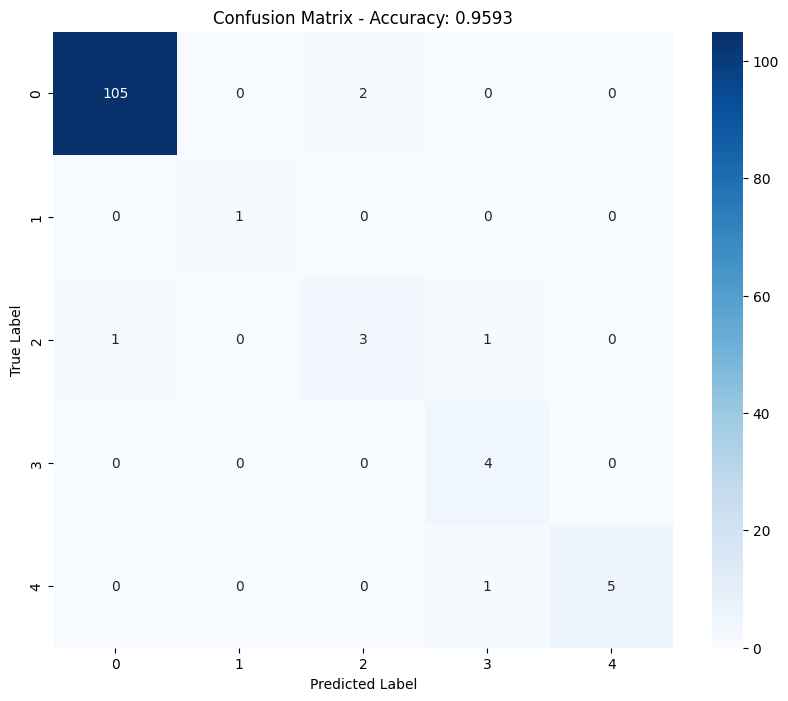


Best model: Random Forest with accuracy: 0.9593


In [18]:
# Evaluate each model
results = {}
for name, model in models.items():
    print(f"\nEvaluating {name}...")
    accuracy, trained_model = evaluate_model(model, X_train_resampled, y_train_resampled, X_test_scaled, y_test)
    results[name] = (accuracy, trained_model)

# Find the best model
best_model_name = max(results.items(), key=lambda x: x[1][0])[0]
best_accuracy, best_model = results[best_model_name]

print(f"\nBest model: {best_model_name} with accuracy: {best_accuracy:.4f}")